# Team Members

* **Student ID:** 0001111416  
  **Full Name:** Alessio Pittiglio  
  **Institutional Email:** alessio.pittiglio@studio.unibo.it

* **Student ID:** 0001086355  
  **Full Name:** Parsa Mastouri Kashani  
  **Institutional Email:** parsa.mastouri@studio.unibo.it

# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

**Important:**

Due to the size limitations of Virtuale and the use of Google Colab (having too many pictures makes the notebook unresponsive), we could not include many images directly in the notebook. Therefore, we have provided the following two links, where you can find the plots for each of our experiments. You can also follow the link that the trainer prints after each training cell for each specific experiment.

In total, we have run more than 100 experiments, and the following links include only a handful of the results.

**Task 1:**
https://wandb.ai/parsa-pmk/Task1?nw=nwuserparsapmk

**Task 2:**
https://wandb.ai/parsa-pmk/Task2/workspace?nw=nwuserparsapmk

## Prerequisites

In [1]:
%pip install -q torchmetrics
%pip install -q torchinfo
%pip install -q torchview

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: alessiopittiglio (alessiopittiglio-university-of-bologna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Imports

In [4]:
import copy
import random
from pathlib import Path
from typing import Any, Dict, List, Tuple
from collections import Counter

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

import torchvision.models as models
from torchvision import transforms as T
from torchvision.transforms import ToPILImage

from torchinfo import summary
from torchview import draw_graph

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torchmetrics.classification.accuracy import Accuracy

from IPython.display import Image as IPython_Image
from tqdm import tqdm

## Making the notebook deterministic and checking for computation resources

In [6]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: The seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


fix_random(seed=42)

In [8]:
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("All good, a GPU is available")
else:
    print("Please set GPU via Edit -> Notebook Settings")

All good, a GPU is available


## Hyperparameters

In [17]:
cfg = {
    # Preprocessing parameters
    "resize_size": 256,
    "crop_size": 224,
    # Training parameters
    "batch_size": 16,
    "num_epochs": 150,
    # Optimizer parameters
    "lr": 1e-3,  # learning rate
    "wd": 1e-4,  # weight decay
    "ls": 0.1,  # label smoothing
    "step_size": 5,
}

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [9]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

fatal: destination path 'ipcv-assignment-2' already exists and is not an empty directory.


We've taken the liberty of adding some extra functions to the class.

In [11]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        if transform is None:
            self.transform = T.Compose(
                [
                    T.Resize((224, 224)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]
            )
        else:
            self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name)
                labels.append(int(label) - 1)
        return names, labels

    def ratio_of_classes(self):
        total = len(self.labels)
        label_counts = Counter(self.labels)

        # Compute ratios
        ratios = {label: count / total for label, count in label_counts.items()}

        # Display results
        for label in label_counts:
            for i, v in enumerate(self.labels):
                if v == label:
                    breed = "_".join(self.names[i].split("_")[:-1])
            print(
                f"breed: {breed:<27} label: {label:<10} count = {label_counts[label]:<5} ratio = {ratios[label]:.2%}"
            )
        print()

        number_of_cats = 0
        number_of_dog = 0
        for i in self.names:
            if self._is_cat(i):
                number_of_cats += 1
            else:
                number_of_dog += 1

        print(f"Number of cats: {number_of_cats}")
        print(f"Number of dogs: {number_of_dog}")
        print(f"Ratio of cats: {number_of_cats / total:.2%}")
        print(f"Ratio of dogs: {number_of_dog / total:.2%}")

    def _is_cat(self, image_name):
        cat_breeds = {
            "Abyssinian",
            "Bengal",
            "Birman",
            "Bombay",
            "British_Shorthair",
            "Egyptian_Mau",
            "Maine_Coon",
            "Persian",
            "Ragdoll",
            "Russian_Blue",
            "Siamese",
            "Sphynx",
        }
        breed = "_".join(image_name.lower().split("_")[:-1])
        return breed in [breed.lower() for breed in cat_breeds]

    def get_dataset_info(self) -> None:
        number_of_items = self.__len__()
        number_of_classes = self.get_num_classes()
        print(f"Number of items: {number_of_items}")
        print(f"Number of classes: {number_of_classes}\n")

    def show_image(self, idx: int, transform=False) -> None:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        name = self.names[idx]

        if transform:
            # Note: Transforms like ToTensor() return tensors, which can't be shown directly
            transformed_img = self.transform(img)

            # If you want to visualize the transformed tensor, convert it back to a PIL image:
            img = ToPILImage()(transformed_img)

        plt.imshow(img)
        plt.title(f"Label: {label}\nname: {name}")
        plt.axis("off")
        plt.show()

In [12]:
train_set = OxfordPetDataset(split="train")
validation_set = OxfordPetDataset(split="val")
test_set = OxfordPetDataset(split="test")

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(validation_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 3669
Validation set size: 1834
Test set size: 1846


The printed information about the training set and the validation set shows us several things:

- We have a total of 3,669 pictures for 37 classes, which is far from enough to learn each class without overfitting. Therefore, we need to rely heavily on data augmentation.
- We need to shuffle the data for each set, as the objects of the same class are all grouped together (this will be done in the dataloader).
- The number of items per class is almost similar, so there is no need to balance the class weights.
- Twelve of the 37 classes in the dataset belong to cats, and the rest to dogs, showing an approximate 1:3 ratio of cats to dogs.

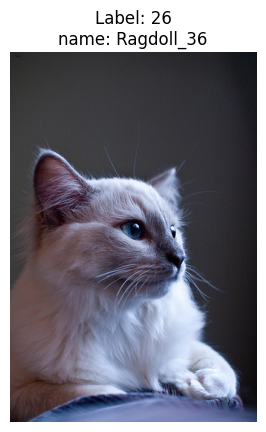

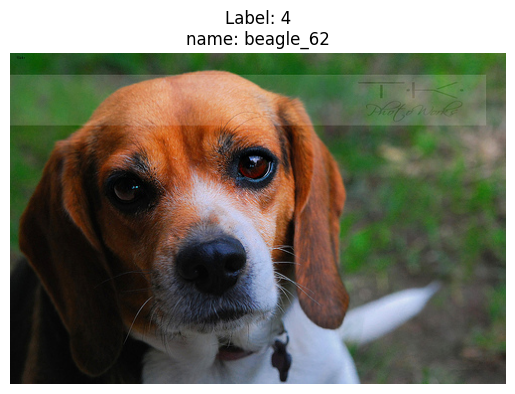

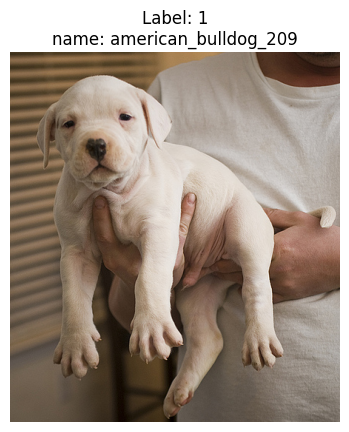

Number of items: 3669
Number of classes: 37

breed: Abyssinian                  label: 0          count = 98    ratio = 2.67%
breed: american_bulldog            label: 1          count = 100   ratio = 2.73%
breed: american_pit_bull_terrier   label: 2          count = 100   ratio = 2.73%
breed: basset_hound                label: 3          count = 100   ratio = 2.73%
breed: beagle                      label: 4          count = 100   ratio = 2.73%
breed: Bengal                      label: 5          count = 100   ratio = 2.73%
breed: Birman                      label: 6          count = 100   ratio = 2.73%
breed: Bombay                      label: 7          count = 88    ratio = 2.40%
breed: boxer                       label: 8          count = 99    ratio = 2.70%
breed: British_Shorthair           label: 9          count = 100   ratio = 2.73%
breed: chihuahua                   label: 10         count = 100   ratio = 2.73%
breed: Egyptian_Mau                label: 11         count = 97 

In [13]:
for _ in range(3):
    i = random.randint(0, len(train_set) - 1)
    train_set.show_image(i)
train_set.get_dataset_info()
train_set.ratio_of_classes()

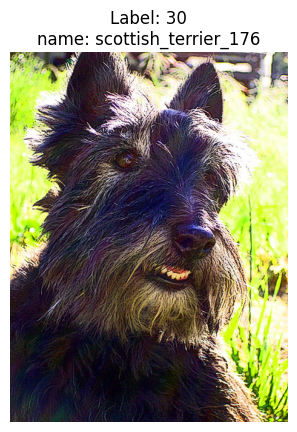

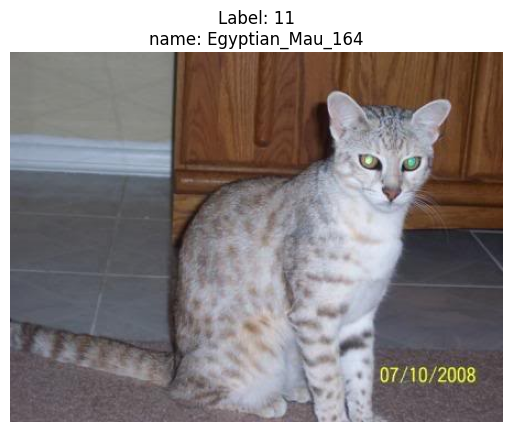

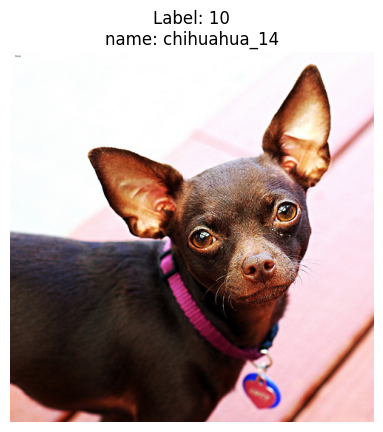

Number of items: 1834
Number of classes: 37

breed: Abyssinian                  label: 0          count = 50    ratio = 2.73%
breed: american_bulldog            label: 1          count = 50    ratio = 2.73%
breed: american_pit_bull_terrier   label: 2          count = 50    ratio = 2.73%
breed: basset_hound                label: 3          count = 50    ratio = 2.73%
breed: beagle                      label: 4          count = 50    ratio = 2.73%
breed: Bengal                      label: 5          count = 50    ratio = 2.73%
breed: Birman                      label: 6          count = 50    ratio = 2.73%
breed: Bombay                      label: 7          count = 47    ratio = 2.56%
breed: boxer                       label: 8          count = 50    ratio = 2.73%
breed: British_Shorthair           label: 9          count = 50    ratio = 2.73%
breed: chihuahua                   label: 10         count = 50    ratio = 2.73%
breed: Egyptian_Mau                label: 11         count = 46 

In [14]:
for _ in range(3):
    i = random.randint(0, len(validation_set) - 1)
    validation_set.show_image(i)
validation_set.get_dataset_info()
validation_set.ratio_of_classes()

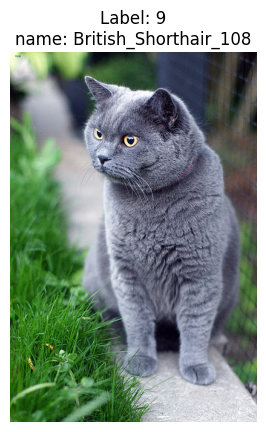

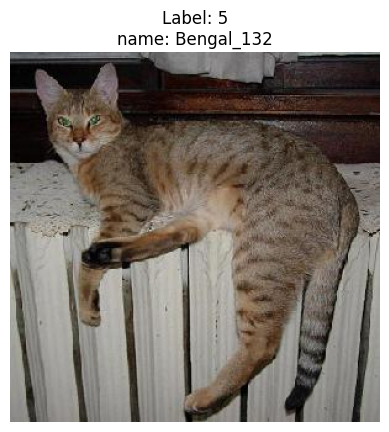

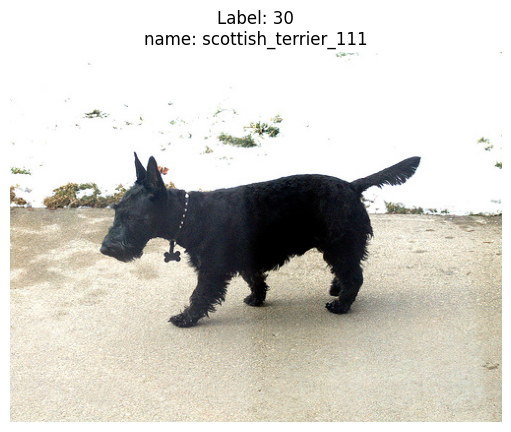

Number of items: 1846
Number of classes: 37

breed: Abyssinian                  label: 0          count = 50    ratio = 2.71%
breed: american_bulldog            label: 1          count = 50    ratio = 2.71%
breed: american_pit_bull_terrier   label: 2          count = 50    ratio = 2.71%
breed: basset_hound                label: 3          count = 50    ratio = 2.71%
breed: beagle                      label: 4          count = 50    ratio = 2.71%
breed: Bengal                      label: 5          count = 50    ratio = 2.71%
breed: Birman                      label: 6          count = 50    ratio = 2.71%
breed: Bombay                      label: 7          count = 49    ratio = 2.65%
breed: boxer                       label: 8          count = 50    ratio = 2.71%
breed: British_Shorthair           label: 9          count = 50    ratio = 2.71%
breed: chihuahua                   label: 10         count = 50    ratio = 2.71%
breed: Egyptian_Mau                label: 11         count = 47 

In [15]:
for _ in range(3):
    i = random.randint(0, len(test_set) - 1)
    test_set.show_image(i)
test_set.get_dataset_info()
test_set.ratio_of_classes()

In [18]:
data_transforms = {
    "train": T.Compose(
        [
            T.RandomResizedCrop(cfg["crop_size"]),
            T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            T.RandomRotation(10),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "val": T.Compose(
        [
            T.Resize(cfg["resize_size"]),
            T.CenterCrop(cfg["crop_size"]),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "test": T.Compose(
        [
            T.Resize(cfg["resize_size"]),
            T.CenterCrop(cfg["crop_size"]),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [19]:
data_train = OxfordPetDataset("train", data_transforms["train"])
data_val = OxfordPetDataset("val", data_transforms["val"])
data_test = OxfordPetDataset("test", data_transforms["test"])

print(f"Train set size: {len(data_train)}")
print(f"Validation set size: {len(data_val)}")
print(f"Test set size: {len(data_test)}")

num_classes = data_train.get_num_classes()
print(f"Number of classes: {num_classes}")

Train set size: 3669
Validation set size: 1834
Test set size: 1846
Number of classes: 37


In [20]:
loader_train = DataLoader(
    data_train,
    batch_size=cfg["batch_size"],
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)
loader_val = DataLoader(
    data_val,
    batch_size=cfg["batch_size"],
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)
loader_test = DataLoader(
    data_test,
    batch_size=cfg["batch_size"],
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

### Training loop

The trainer uses AdamW with a OneCycleLR scheduler and saves the best model based on validation performance. As a result, we don't need to choose an exact number of epochs. We only need to set an upper bound.

In [21]:
class Trainer:
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        test_loader: DataLoader,
        device: torch.device,
        num_classes: int,
        plot_cm: bool = False,
    ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]
        self.plot_cm = plot_cm

        self.model = model.to(device)
        self.optimizer = AdamW(
            self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"]
        )
        num_steps = self.num_epochs * len(train_loader)
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=cfg["lr"],  # e.g., 1e-2
            total_steps=num_steps,
            div_factor=25.0,  # initial LR = max_lr / 25 = 4e-4
            final_div_factor=1e4,  # final LR = max_lr / 1e4 = 1e-6
            anneal_strategy="cos",  # or "linear"
            pct_start=0.3,  # 30% of steps for increasing LR
        )

        self.step = 0
        self.best_acc = 0.0

        wandb.init(
            name=cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=cfg
        )
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:
        for _ in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels, label_smoothing=cfg["ls"])
                if torch.isnan(loss):
                    print("Loss is NaN!")
                    break

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})

                self.step += 1

            self.eval("train")
            self.eval("val")

        self.test()
        wandb.finish()

    @torch.no_grad()
    def eval(self, split: str) -> None:
        self.model.eval()

        loader = self.train_loader if split == "train" else self.val_loader
        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        self.logfn({f"{split}/loss": loss})
        self.logfn({f"{split}/acc": accuracy})

        if accuracy > self.best_acc and split == "val":
            self.best_acc = accuracy
            torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            self.best_model = copy.deepcopy(self.model)

    @torch.no_grad()
    def test(self) -> None:
        self.best_model.eval()

        all_preds = []
        all_labels = []

        for imgs, labels in self.test_loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            outputs = self.best_model(imgs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        # Convert to numpy arrays
        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()

        # Classification metrics
        cm = confusion_matrix(
            all_labels, all_preds, normalize="true"
        )  # use normalize='true' or remove for raw counts
        report = classification_report(
            all_labels, all_preds, output_dict=True, zero_division=0
        )
        report_str = classification_report(all_labels, all_preds, zero_division=0)

        # Print classification report in Colab
        print("Classification Report:\n", report_str)

        # Log summary metrics to wandb
        wandb.log(
            {
                "test/accuracy": report["accuracy"],
                "test/macro_avg_precision": report["macro avg"]["precision"],
                "test/macro_avg_recall": report["macro avg"]["recall"],
                "test/macro_avg_f1": report["macro avg"]["f1-score"],
                "test/weighted_avg_precision": report["weighted avg"]["precision"],
                "test/weighted_avg_recall": report["weighted avg"]["recall"],
                "test/weighted_avg_f1": report["weighted avg"]["f1-score"],
            }
        )

        # Confusion matrix plot
        fig, ax = plt.subplots(figsize=(14, 12))
        sns.heatmap(
            cm,
            annot=False,  # set True for values in boxes
            cmap="Blues",
            xticklabels=[str(i) for i in range(self.num_classes)],
            yticklabels=[str(i) for i in range(self.num_classes)],
        )
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_title("Normalized Confusion Matrix")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()

        # Show inline in Colab
        if self.plot_cm:
            plt.show()

        # Log image to wandb
        wandb.log({"test/confusion_matrix": wandb.Image(fig)})

        # Close to free memory
        plt.close(fig)

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-shelf PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

In [ ]:
WANDB_PROJECT = "Task1"

## Baseline models

As can be seen, since our dataset is fairly balanced between classes and we have 37 distinct classes, the accuracy of our dummy classifier, regardless of the strategy, is about 3%, which aligns with dividing 100 by 37 (100/37 ≈ 2.7).

In [ ]:
# Dummy features
X_train = np.zeros((len(train_set), 1))
y_train = [label for _, label in train_set]

X_test = np.zeros((len(test_set), 1))
y_test = [label for _, label in test_set]

### Uniform dummy classifier

In [ ]:
# Uniform strategy since dataset is balanced
dummy = DummyClassifier(strategy="uniform", random_state=42)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Baseline Accuracy: 0.02925243770314193
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.04      0.04      0.04        50
           3       0.02      0.02      0.02        50
           4       0.02      0.02      0.02        50
           5       0.02      0.02      0.02        50
           6       0.02      0.02      0.02        50
           7       0.00      0.00      0.00        49
           8       0.02      0.02      0.02        50
           9       0.02      0.02      0.02        50
          10       0.04      0.04      0.04        50
          11       0.02      0.02      0.02        47
          12       0.02      0.02      0.02        50
          13       0.02      0.02      0.02        50
          14       0.04      0.04      0.04        50
          15       0.00      0.00      0.00        50
          16       0.02      0.02      0.0

### Constant dummy classifier

In [ ]:
# Constant strategy since dataset is balanced
dummy = DummyClassifier(strategy="constant", constant=1)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Baseline Accuracy: 0.027085590465872156
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.03      1.00      0.05        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        50
           7       0.00      0.00      0.00        49
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        50
          10       0.00      0.00      0.00        50
          11       0.00      0.00      0.00        47
          12       0.00      0.00      0.00        50
          13       0.00      0.00      0.00        50
          14       0.00      0.00      0.00        50
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.

### Most frequent dummy classifier

In [ ]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Baseline Accuracy: 0.027085590465872156
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.03      1.00      0.05        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        50
           7       0.00      0.00      0.00        49
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        50
          10       0.00      0.00      0.00        50
          11       0.00      0.00      0.00        47
          12       0.00      0.00      0.00        50
          13       0.00      0.00      0.00        50
          14       0.00      0.00      0.00        50
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.

### Simple Baseline CNN (not following best practices and low parameter count)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=37):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  # -> [B, 8, 224, 224]
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # -> [B, 16, 112, 112]
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # -> [B, 32, 56, 56]
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # -> [B, 64, 28, 28]
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # -> [B, 128, 14, 14]
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # -> [B, 256, 7, 7]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # -> [B, 256, 1, 1]
        self.fc = nn.Linear(256, num_classes)  # Final classifier

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 16, 56, 56]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 32, 28, 28]
        x = self.pool(F.relu(self.conv4(x)))  # [B, 64, 14, 14]
        x = self.pool(F.relu(self.conv5(x)))  # [B, 128, 7, 7]
        x = self.pool(F.relu(self.conv6(x)))  # [B, 256, 3, 3]

        x = self.global_avg_pool(x)  # [B, 256, 1, 1]
        x = torch.flatten(x, 1)  # [B, 256]
        x = self.dropout(x)
        x = self.fc(x)  # [B, num_classes]
        return x

In [ ]:
# Instantiate model and print
model = SimpleCNN().to(device)
print(model)


# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Total trainable parameters: {count_parameters(model):,}")

SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=256, out_features=37, bias=True)
)
Total trainable parameters: 403,061


In [ ]:
# -----------------------------
# Get first batch from train_loader
data_iter = iter(loader_train)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Initialize model, loss, optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop: overfit on a single batch
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Calculate accuracy on the same batch
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)

    print(
        f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%"
    )

    # Optional early stop if fully overfit
    if accuracy == 1.0:
        print("✅ Fully overfitted the batch!")
        break

Epoch 1/200 - Loss: 3.6225 - Accuracy: 6.25%
Epoch 2/200 - Loss: 3.5956 - Accuracy: 0.00%
Epoch 3/200 - Loss: 3.5571 - Accuracy: 12.50%
Epoch 4/200 - Loss: 3.4771 - Accuracy: 12.50%
Epoch 5/200 - Loss: 3.3134 - Accuracy: 18.75%
Epoch 6/200 - Loss: 3.1696 - Accuracy: 18.75%
Epoch 7/200 - Loss: 3.0457 - Accuracy: 12.50%
Epoch 8/200 - Loss: 2.9928 - Accuracy: 12.50%
Epoch 9/200 - Loss: 2.7364 - Accuracy: 12.50%
Epoch 10/200 - Loss: 2.7710 - Accuracy: 12.50%
Epoch 11/200 - Loss: 2.6278 - Accuracy: 25.00%
Epoch 12/200 - Loss: 2.6241 - Accuracy: 18.75%
Epoch 13/200 - Loss: 2.9834 - Accuracy: 0.00%
Epoch 14/200 - Loss: 2.6564 - Accuracy: 18.75%
Epoch 15/200 - Loss: 2.8626 - Accuracy: 6.25%
Epoch 16/200 - Loss: 2.8375 - Accuracy: 6.25%
Epoch 17/200 - Loss: 2.6761 - Accuracy: 25.00%
Epoch 18/200 - Loss: 2.7039 - Accuracy: 25.00%
Epoch 19/200 - Loss: 2.6790 - Accuracy: 18.75%
Epoch 20/200 - Loss: 2.6680 - Accuracy: 6.25%
Epoch 21/200 - Loss: 2.6518 - Accuracy: 12.50%
Epoch 22/200 - Loss: 2.4749 

In [ ]:
cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 16,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 1e-3,
    "wd": 1e-4,
    "ls": 0.1,
    "step_size": 5,
}

cfg["run_name"] = "SimpleCNN-Baseline"

trainer = Trainer(model, loader_train, loader_val, loader_test, device, num_classes)
trainer.train()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.24      0.19        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.18      0.24      0.21        50
           4       0.11      0.12      0.11        50
           5       0.17      0.60      0.27        50
           6       0.17      0.10      0.12        50
           7       0.38      0.41      0.39        49
           8       0.20      0.26      0.23        50
           9       0.16      0.06      0.09        50
          10       0.04      0.04      0.04        50
          11       0.23      0.15      0.18        47
          12       0.00      0.00      0.00        50
          13       0.20      0.18      0.19        50
          14       0.19      0.34      0.25        50
          15       0.17      0.44      0.24        50
          16       0.11      0.08      0.09        50
   

Without regularization, data augmentation, and with a fixed learning rate, the model easily achieves 100% accuracy on the training set. This demonstrates the necessity of using augmentation and regularization techniques, especially as the number of parameters increases.

This demonstrates that a model with only 400,000 parameters can easily overfit the training set and achieve 100% training accuracy. However, such performance does not necessarily indicate that the model has learned meaningful or generalizable representations of the data and its underlying features. As a practical constraint and rule of thumb, we chose to limit the model size to under one million parameters.

Moreover, considering that ResNet-18 - an architecture with approximately 11 million parameters and pre-trained on ImageNet - achieves around 80% accuracy on our task, it is reasonable to assume that capping the parameter count at one million is a sound design decision. This is especially true given the relatively small size and lower complexity of our dataset compared to ImageNet. In fact, recent lightweight architectures, such as MobileNetV2 with approximately 5 million parameters, have been shown to outperform ResNet-18 in various tasks, further supporting the feasibility of using compact models for effective representation learning.

<figure style="text-align: center;">
  <img src="https://www.researchgate.net/publication/369624227/figure/fig8/AS:11431281131552328@1680145503560/The-architecture-of-the-MobileNetV2-with-a-sample-input-image-and-19-residual-bottleneck.png" alt="accumulator-heatmap">
  <figcaption><em>Figure 1: Architecture of MobileNetV2.</em></figcaption>
</figure>

## Final model

We selected **MobileNetV2** (with some customization via the width multiplier) as the primary architecture for our task due to its strong performance relative to its compact size. As mentioned earlier, the original MobileNetV2 model contains approximately 5 million parameters and has been shown to outperform larger models such as ResNet-18 in various tasks, particularly when model efficiency is a critical requirement.

MobileNetV2 incorporates several architectural innovations, including:

- **Residual connections**, which improve gradient flow and allow for deeper networks.  
- **Depthwise separable convolutions** (a form of group convolution), which significantly reduce parameter count and computational complexity.
- **Bottleneck blocks**, which expand and compress feature dimensions to support efficient representation learning.
- **Batch normalization**, which stabilizes and accelerates training.
- **Dropout**, which serves as a regularization technique to mitigate overfitting.

While alternative lightweight architectures such as **ShuffleNet** and **EfficientNet** were considered, we ultimately chose MobileNetV2 because it strikes an effective balance between architectural sophistication and ease of training. It is straightforward to implement, well-documented, and achieves strong performance without requiring extensive hyperparameter tuning.

Although a newer variant, **MobileNetV3**, is available, we opted not to use it. MobileNetV3 introduces additional complexity through components such as **Swish activations**, **Squeeze-and-Excitation attention blocks**, and modules optimized via **Neural Architecture Search (NAS)**. These features can make the model more difficult to train from scratch. Since MobileNetV3 is primarily designed for transfer learning using pretrained weights, it was not suitable for our scenario, which involves training from scratch on a relatively small dataset.

### Our customization of MobileNetV2:

MobileNetV2 was designed for efficient inference on mobile and embedded devices. It uses depthwise separable convolutions, inverted residual blocks, and linear bottlenecks to drastically reduce the number of operations and parameters. By default, MobileNetV2 uses ReLU6 activations, which are better suited for quantized inference on mobile hardware.

However, since our model runs on an NVIDIA GPU with full floating-point precision, we replaced ReLU6 with standard ReLU activations. This change simplifies the computational graph and has minimal to no impact on accuracy in our floating-point environment.

To further reduce model size and computational cost, we applied a width multiplier of 0.5. This scales down the number of channels in each layer to 50% of the original architecture, bringing the parameter count from approximately 3.4 million (MobileNetV2 with width multiplier 1.0) down to about 700,000 parameters. This results in a lightweight and efficient model that still retains strong performance for our use case.

We also increased the dropout probability from the standard 0.2 in the original model to 0.5 in our testing, but this resulted in worse performance.

In [ ]:
class ConvBNReLU(nn.Sequential):
    """
    Depthwise Separable Convolution with Batch Normalization and ReLU activation.
    This defines a convolution + batch normalization + ReLU activation block.

    groups=1 means it's a normal convolution by default.

    If groups equals the number of input channels, it becomes a depthwise convolution.

    Padding is set so that the output has the same spatial size when stride=1.
    """

    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(
                in_planes,
                out_planes,
                kernel_size,
                stride,
                padding,
                groups=groups,
                bias=False,
            ),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(),
        )

    def __repr__(self):
        return (
            f"ConvBNReLU({self.in_planes} -> {self.out_planes}, "
            f"k={self.kernel_size}, s={self.stride}, g={self.groups})"
        )


# Inverted Residual Block
class InvertedResidual(nn.Module):
    """
    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride for the depthwise convolution. Controls spatial downsampling.
                      Usually 1 (no downsampling) or 2 (downsampling by factor 2).
        expand_ratio (int or float): Expansion factor to increase the number of channels
                                    before the depthwise convolution. The input channels
                                    are multiplied by this factor to get the hidden dimension.

    Description:
        The block first expands the input channels by 'expand_ratio' using a pointwise (1x1) convolution,
        then applies a depthwise convolution with specified stride, and finally projects the
        channels back to 'oup' using another pointwise convolution. A residual connection
        is applied if stride == 1 and input/output channels are the same.
    """

    def __init__(self, inp, oup, stride, expand_ratio, use_res_connect=True):
        super().__init__()
        self.stride = stride

        # number of channels in the expansion
        hidden_dim = int(inp * expand_ratio)

        # It's only residual if the number of inputs and outputs are the same and we have a stride of 1
        # (only when the input and output are compatible to add to each other without any extra operation)
        self.use_res_connect = self.stride == 1 and inp == oup and use_res_connect

        layers = []
        if expand_ratio != 1:
            # Pointwise
            # if we're expanding, the following pointwise layer is gonna exapnd the number of channels
            # to the set amount. If we're not expanding, it's not needed.
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))

        # Depthwise
        # Operation on each channels seperately
        layers.append(
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim)
        )

        # Pointwise-linear
        layers.append(
            nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False)
        )
        layers.append(nn.BatchNorm2d(oup))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

    def __repr__(self):
        return (
            f"InvertedResidual(inp={self.inp}, oup={self.oup}, "
            f"stride={self.stride}, expand_ratio={self.expand_ratio})"
        )


# MobileNetV2
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=37, width_mult=0.5, dropout=0.2):
        super().__init__()
        # Config: t, c, n, s
        # t: expansion factor, c: output channels, n: number of blocks, s: stride of first block
        self.cfgs = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # First layer
        input_channel = int(32 * width_mult)
        self.last_channel = int(1280 * width_mult) if width_mult > 1.0 else 1280

        # stem layer
        # 3 channels coming in and 32*width_mult coming out
        # this is not a residual block
        layers = [ConvBNReLU(3, input_channel, stride=2)]

        # Bottleneck layers
        for t, c, n, s in self.cfgs:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(
                    InvertedResidual(
                        input_channel, output_channel, stride, expand_ratio=t
                    )
                )
                input_channel = output_channel

        # Last conv layer
        layers.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        self.features = nn.Sequential(*layers)

        # Classifier
        if dropout:
            self.classifier = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(self.last_channel, num_classes),
            )
        else:
            self.classifier = nn.Linear(self.last_channel, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x


model = MobileNetV2(num_classes=37).to(device)
x = torch.randn(1, 3, 224, 224).to(device)
out = model(x)
print(out.shape)

summary(
    model,
    input_size=(
        1,
        3,
        cfg["crop_size"],
        cfg["crop_size"],
    ),  # batch_size must be included
    device=device.type,
    depth=2,
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
)

All good, a GPU is available
torch.Size([1, 37])


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2                                   [1, 3, 224, 224]          [1, 37]                   --                        --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─ConvBNReLU: 2-1                        [1, 3, 224, 224]          [1, 16, 112, 112]         464                       --                        5,419,040
│    └─InvertedResidual: 2-2                  [1, 16, 112, 112]         [1, 8, 112, 112]          320                       --                        3,412,016
│    └─InvertedResidual: 2-3                  [1, 8, 112, 112]          [1, 12, 56, 56]           1,608                     --                        7,978,200
│    └─InvertedResidual: 2-4                  [1, 12, 

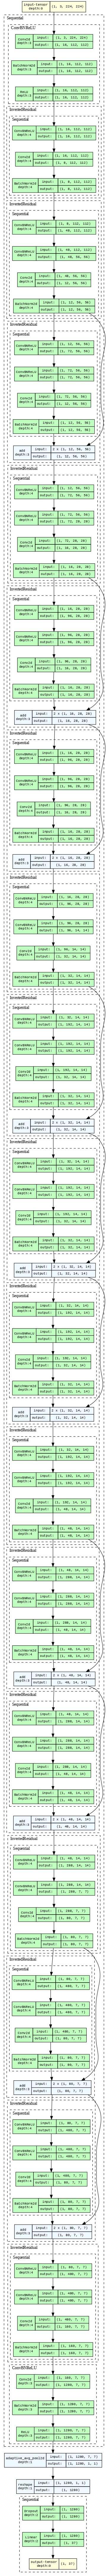

In [ ]:
graph = draw_graph(
    model,
    input_size=(1, 3, 224, 224),
    expand_nested=True,  # already doing this — good!
    depth=4,  # increase this to show deeper modules (default is 3)
)
graph.visual_graph.render("mobilenetv2_tree", format="png")
IPython_Image(filename="mobilenetv2_tree.png")

### Best performing model

It should be emphasized that we aimed to keep the number of parameters below 1 million.

In [ ]:
cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 2e-3,
    "wd": 1e-4,
    "ls": 0.1,
    "step_size": 5,
    "run_name": "batch32",
}

In [ ]:
loader_train = DataLoader(
    data_train,
    batch_size=cfg["batch_size"],
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)
loader_val = DataLoader(
    data_val,
    batch_size=cfg["batch_size"],
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)
loader_test = DataLoader(
    data_test,
    batch_size=cfg["batch_size"],
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

In [ ]:
model_batch32 = MobileNetV2(num_classes=37).to(device)

trainer = Trainer(
    model_batch32, loader_train, loader_val, loader_test, device, num_classes
)
trainer.train()

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.78        50
           1       0.62      0.62      0.62        50
           2       0.41      0.36      0.38        50
           3       0.68      0.78      0.73        50
           4       0.63      0.62      0.63        50
           5       0.71      0.78      0.74        50
           6       0.69      0.92      0.79        50
           7       0.79      0.94      0.86        49
           8       0.77      0.66      0.71        50
           9       0.77      0.80      0.78        50
          10       0.64      0.60      0.62        50
          11       0.82      0.87      0.85        47
          12       0.65      0.52      0.58        50
          13       0.62      0.60      0.61        50
          14       0.75      0.66      0.70        50
          15       0.65      0.82      0.73        50
          16       0.68      0.68      0.68        50
   

<figure style="text-align: center;">
  <img src="https://i.ibb.co/rKVSX13z/immagine.png" alt="best-performing-model">
</figure>

## Ablation studies

## Architectural changes

### Removing batch normalization

Before, we were disabling bias for the convolutional layers followed by batch normalization to avoid redundant parameters. However, now that they are removed, we have enabled bias again.

We did know that MobileNetV2 is based on using BatchNorm as a fundamental block of its architecture, but to our surprise, removing BatchNorm rendered the model completely incapable of learning for our task.

We wrote another Colab cell to sanity-check this phenomenon and see whether there was anything wrong with our implementation. It proved that the model can memorize the first batch in the training set, but it took around 600 loops.

In [ ]:
class ConvBNReLU_noBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(
                in_planes,
                out_planes,
                kernel_size,
                stride,
                padding,
                groups=groups,
                bias=True,
            ),
            # nn.BatchNorm2d(out_planes),
            nn.ReLU(),
        )


# Inverted Residual Block
class InvertedResidual_noBN(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_res_connect=True):
        super().__init__()
        self.stride = stride
        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup and use_res_connect

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU_noBN(inp, hidden_dim, kernel_size=1))

        layers.append(
            ConvBNReLU_noBN(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim)
        )

        layers.append(
            nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=True)
        )
        # layers.append(nn.BatchNorm2d(oup))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2_noBN(nn.Module):
    def __init__(self, num_classes=37, width_mult=0.5, dropout=0.2):
        super().__init__()
        self.cfgs = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        input_channel = int(32 * width_mult)
        self.last_channel = int(1280 * width_mult) if width_mult > 1.0 else 1280
        layers = [ConvBNReLU_noBN(3, input_channel, stride=2)]
        for t, c, n, s in self.cfgs:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(
                    InvertedResidual_noBN(
                        input_channel, output_channel, stride, expand_ratio=t
                    )
                )
                input_channel = output_channel
        layers.append(ConvBNReLU_noBN(input_channel, self.last_channel, kernel_size=1))
        self.features = nn.Sequential(*layers)
        if dropout:
            self.classifier = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(self.last_channel, num_classes),
            )
        else:
            self.classifier = nn.Linear(self.last_channel, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x


model_noBN = MobileNetV2_noBN(num_classes=37).to(device)
x = torch.randn(1, 3, 224, 224).to(device)
out = model_noBN(x)
print(out.shape)

summary(
    model_noBN,
    input_size=(
        1,
        3,
        cfg["crop_size"],
        cfg["crop_size"],
    ),  # batch_size must be included
    device=device.type,
    depth=2,
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
)

torch.Size([1, 37])


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2_noBN                              [1, 3, 224, 224]          [1, 37]                   --                        --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─ConvBNReLU_noBN: 2-1                   [1, 3, 224, 224]          [1, 16, 112, 112]         448                       --                        5,619,712
│    └─InvertedResidual_noBN: 2-2             [1, 16, 112, 112]         [1, 8, 112, 112]          296                       --                        3,713,024
│    └─InvertedResidual_noBN: 2-3             [1, 8, 112, 112]          [1, 12, 56, 56]           1,500                     --                        8,768,256
│    └─InvertedResidual_noBN: 2-4             [1, 12, 

In [ ]:
cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 1e-4,
    "wd": 1e-4,
    "ls": 0.1,
    "step_size": 5,
    "run_name": "NoBatchNorm",
}

In [ ]:
trainer = Trainer(
    model_noBN, loader_train, loader_val, loader_test, device, num_classes
)
trainer.train()

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        50
           7       0.00      0.00      0.00        49
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        50
          10       0.00      0.00      0.00        50
          11       0.00      0.00      0.00        47
          12       0.00      0.00      0.00        50
          13       0.00      0.00      0.00        50
          14       0.00      0.00      0.00        50
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00        50
   

These are the results we obtained on Weights & Biases:


<figure style="text-align: center;">
  <img src="https://i.ibb.co/SXQtgyt7/removing-batch-norm.png" alt="removing-batch-norm">
</figure>

The accuracy shows that the model is completely guessing and has not learned anything at all.

We thought that perhaps our implementation was faulty, and that the gradients were completely shut off, but the cell below shows that the model can learn (barely).

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Unique labels in batch: [0, 1, 4, 6, 8, 9, 10, 11, 14, 15, 16, 19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 34, 36]

Starting overfitting test...


  2%|▏         | 15/1000 [00:00<00:21, 46.16it/s]

Epoch [10/1000], Loss: 3.5547, Accuracy: 12.50%


  2%|▎         | 25/1000 [00:00<00:21, 45.90it/s]

Epoch [20/1000], Loss: 3.4707, Accuracy: 12.50%


  4%|▎         | 35/1000 [00:00<00:21, 45.68it/s]

Epoch [30/1000], Loss: 3.3564, Accuracy: 12.50%


  4%|▍         | 45/1000 [00:00<00:21, 45.06it/s]

Epoch [40/1000], Loss: 3.2178, Accuracy: 12.50%


  6%|▌         | 55/1000 [00:01<00:21, 44.80it/s]

Epoch [50/1000], Loss: 3.1093, Accuracy: 12.50%


  6%|▋         | 65/1000 [00:01<00:20, 44.93it/s]

Epoch [60/1000], Loss: 3.0723, Accuracy: 12.50%


  8%|▊         | 75/1000 [00:01<00:20, 45.20it/s]

Epoch [70/1000], Loss: 3.0645, Accuracy: 12.50%


  8%|▊         | 85/1000 [00:01<00:20, 45.16it/s]

Epoch [80/1000], Loss: 3.0311, Accuracy: 12.50%


 10%|▉         | 95/1000 [00:02<00:20, 44.70it/s]

Epoch [90/1000], Loss: 3.0476, Accuracy: 12.50%


 10%|█         | 105/1000 [00:02<00:19, 44.91it/s]

Epoch [100/1000], Loss: 3.0204, Accuracy: 12.50%


 12%|█▏        | 115/1000 [00:02<00:19, 45.25it/s]

Epoch [110/1000], Loss: 3.0575, Accuracy: 12.50%


 12%|█▎        | 125/1000 [00:02<00:19, 45.34it/s]

Epoch [120/1000], Loss: 3.0329, Accuracy: 12.50%


 14%|█▎        | 135/1000 [00:02<00:19, 45.04it/s]

Epoch [130/1000], Loss: 3.0509, Accuracy: 12.50%


 14%|█▍        | 145/1000 [00:03<00:19, 44.91it/s]

Epoch [140/1000], Loss: 3.0367, Accuracy: 12.50%


 16%|█▌        | 155/1000 [00:03<00:18, 45.06it/s]

Epoch [150/1000], Loss: 3.0252, Accuracy: 12.50%


 16%|█▋        | 165/1000 [00:03<00:18, 45.25it/s]

Epoch [160/1000], Loss: 3.0267, Accuracy: 12.50%


 18%|█▊        | 175/1000 [00:03<00:18, 45.04it/s]

Epoch [170/1000], Loss: 3.0327, Accuracy: 12.50%


 18%|█▊        | 185/1000 [00:04<00:18, 44.86it/s]

Epoch [180/1000], Loss: 3.0303, Accuracy: 12.50%


 20%|█▉        | 195/1000 [00:04<00:17, 44.97it/s]

Epoch [190/1000], Loss: 3.0799, Accuracy: 12.50%


 20%|██        | 205/1000 [00:04<00:17, 45.18it/s]

Epoch [200/1000], Loss: 3.0395, Accuracy: 12.50%


 22%|██▏       | 215/1000 [00:04<00:17, 45.16it/s]

Epoch [210/1000], Loss: 3.0596, Accuracy: 12.50%


 22%|██▎       | 225/1000 [00:04<00:17, 44.99it/s]

Epoch [220/1000], Loss: 3.0654, Accuracy: 12.50%


 24%|██▎       | 235/1000 [00:05<00:17, 44.94it/s]

Epoch [230/1000], Loss: 3.0685, Accuracy: 12.50%


 24%|██▍       | 245/1000 [00:05<00:16, 45.05it/s]

Epoch [240/1000], Loss: 3.0690, Accuracy: 12.50%


 26%|██▌       | 255/1000 [00:05<00:16, 45.08it/s]

Epoch [250/1000], Loss: 3.0263, Accuracy: 12.50%


 26%|██▋       | 265/1000 [00:05<00:16, 44.89it/s]

Epoch [260/1000], Loss: 3.0623, Accuracy: 12.50%


 28%|██▊       | 275/1000 [00:06<00:16, 44.92it/s]

Epoch [270/1000], Loss: 3.0613, Accuracy: 12.50%


 28%|██▊       | 285/1000 [00:06<00:15, 45.03it/s]

Epoch [280/1000], Loss: 3.0577, Accuracy: 12.50%


 30%|██▉       | 295/1000 [00:06<00:15, 45.18it/s]

Epoch [290/1000], Loss: 3.0483, Accuracy: 12.50%


 30%|███       | 305/1000 [00:06<00:15, 45.00it/s]

Epoch [300/1000], Loss: 3.0194, Accuracy: 12.50%


 32%|███▏      | 315/1000 [00:06<00:15, 44.99it/s]

Epoch [310/1000], Loss: 3.0948, Accuracy: 12.50%


 32%|███▎      | 325/1000 [00:07<00:15, 44.82it/s]

Epoch [320/1000], Loss: 3.0315, Accuracy: 12.50%


 34%|███▎      | 335/1000 [00:07<00:14, 45.16it/s]

Epoch [330/1000], Loss: 3.0534, Accuracy: 12.50%


 34%|███▍      | 345/1000 [00:07<00:14, 44.74it/s]

Epoch [340/1000], Loss: 3.0188, Accuracy: 12.50%


 36%|███▌      | 355/1000 [00:07<00:14, 44.78it/s]

Epoch [350/1000], Loss: 3.0592, Accuracy: 12.50%


 36%|███▋      | 365/1000 [00:08<00:14, 44.76it/s]

Epoch [360/1000], Loss: 3.0417, Accuracy: 12.50%


 38%|███▊      | 375/1000 [00:08<00:13, 44.95it/s]

Epoch [370/1000], Loss: 3.0472, Accuracy: 12.50%


 38%|███▊      | 385/1000 [00:08<00:13, 44.97it/s]

Epoch [380/1000], Loss: 3.0172, Accuracy: 12.50%


 40%|███▉      | 395/1000 [00:08<00:13, 44.81it/s]

Epoch [390/1000], Loss: 3.0805, Accuracy: 12.50%


 40%|████      | 405/1000 [00:08<00:13, 44.87it/s]

Epoch [400/1000], Loss: 3.0652, Accuracy: 12.50%


 42%|████▏     | 415/1000 [00:09<00:13, 44.88it/s]

Epoch [410/1000], Loss: 3.0160, Accuracy: 12.50%


 42%|████▎     | 425/1000 [00:09<00:12, 44.98it/s]

Epoch [420/1000], Loss: 3.0167, Accuracy: 12.50%


 44%|████▎     | 435/1000 [00:09<00:12, 44.94it/s]

Epoch [430/1000], Loss: 3.0542, Accuracy: 12.50%


 44%|████▍     | 445/1000 [00:09<00:12, 44.89it/s]

Epoch [440/1000], Loss: 3.0321, Accuracy: 12.50%


 46%|████▌     | 455/1000 [00:10<00:12, 44.70it/s]

Epoch [450/1000], Loss: 3.0434, Accuracy: 12.50%


 46%|████▋     | 465/1000 [00:10<00:11, 44.78it/s]

Epoch [460/1000], Loss: 3.0426, Accuracy: 12.50%


 48%|████▊     | 475/1000 [00:10<00:11, 44.87it/s]

Epoch [470/1000], Loss: 3.0569, Accuracy: 12.50%


 48%|████▊     | 485/1000 [00:10<00:11, 44.77it/s]

Epoch [480/1000], Loss: 3.0401, Accuracy: 12.50%


 50%|████▉     | 495/1000 [00:11<00:11, 44.80it/s]

Epoch [490/1000], Loss: 3.0667, Accuracy: 12.50%


 50%|█████     | 505/1000 [00:11<00:11, 44.73it/s]

Epoch [500/1000], Loss: 3.0514, Accuracy: 12.50%


 52%|█████▏    | 515/1000 [00:11<00:10, 44.90it/s]

Epoch [510/1000], Loss: 3.0655, Accuracy: 12.50%


 52%|█████▎    | 525/1000 [00:11<00:10, 44.74it/s]

Epoch [520/1000], Loss: 3.0799, Accuracy: 12.50%


 54%|█████▎    | 535/1000 [00:11<00:10, 44.74it/s]

Epoch [530/1000], Loss: 3.0533, Accuracy: 12.50%


 55%|█████▍    | 545/1000 [00:12<00:10, 44.69it/s]

Epoch [540/1000], Loss: 2.9942, Accuracy: 12.50%


 56%|█████▌    | 555/1000 [00:12<00:09, 44.80it/s]

Epoch [550/1000], Loss: 3.0307, Accuracy: 12.50%


 56%|█████▋    | 565/1000 [00:12<00:09, 44.75it/s]

Epoch [560/1000], Loss: 3.0079, Accuracy: 12.50%


 57%|█████▊    | 575/1000 [00:12<00:09, 44.67it/s]

Epoch [570/1000], Loss: 3.0071, Accuracy: 12.50%


 58%|█████▊    | 585/1000 [00:13<00:09, 44.55it/s]

Epoch [580/1000], Loss: 2.9803, Accuracy: 9.38%


 60%|█████▉    | 595/1000 [00:13<00:09, 44.67it/s]

Epoch [590/1000], Loss: 2.9498, Accuracy: 9.38%


 60%|██████    | 605/1000 [00:13<00:08, 44.82it/s]

Epoch [600/1000], Loss: 2.8888, Accuracy: 3.12%


 62%|██████▏   | 615/1000 [00:13<00:08, 44.68it/s]

Epoch [610/1000], Loss: 2.6796, Accuracy: 15.62%


 62%|██████▎   | 625/1000 [00:13<00:08, 44.61it/s]

Epoch [620/1000], Loss: 2.6260, Accuracy: 15.62%


 64%|██████▎   | 635/1000 [00:14<00:08, 44.63it/s]

Epoch [630/1000], Loss: 2.3635, Accuracy: 25.00%


 64%|██████▍   | 645/1000 [00:14<00:07, 44.75it/s]

Epoch [640/1000], Loss: 2.3368, Accuracy: 21.88%


 66%|██████▌   | 655/1000 [00:14<00:07, 44.73it/s]

Epoch [650/1000], Loss: 1.7984, Accuracy: 37.50%


 66%|██████▋   | 665/1000 [00:14<00:07, 44.69it/s]

Epoch [660/1000], Loss: 1.6767, Accuracy: 40.62%


 68%|██████▊   | 675/1000 [00:15<00:07, 44.65it/s]

Epoch [670/1000], Loss: 1.4675, Accuracy: 46.88%


 68%|██████▊   | 685/1000 [00:15<00:07, 44.72it/s]

Epoch [680/1000], Loss: 1.0853, Accuracy: 65.62%


 70%|██████▉   | 695/1000 [00:15<00:06, 44.74it/s]

Epoch [690/1000], Loss: 1.0501, Accuracy: 59.38%


 70%|███████   | 705/1000 [00:15<00:06, 44.64it/s]

Epoch [700/1000], Loss: 1.0662, Accuracy: 62.50%


 72%|███████▏  | 715/1000 [00:15<00:06, 44.55it/s]

Epoch [710/1000], Loss: 0.9071, Accuracy: 65.62%


 72%|███████▎  | 725/1000 [00:16<00:06, 44.53it/s]

Epoch [720/1000], Loss: 0.7012, Accuracy: 71.88%


 74%|███████▎  | 735/1000 [00:16<00:05, 44.58it/s]

Epoch [730/1000], Loss: 0.6102, Accuracy: 75.00%


 74%|███████▍  | 745/1000 [00:16<00:05, 44.53it/s]

Epoch [740/1000], Loss: 0.3222, Accuracy: 87.50%


 76%|███████▌  | 755/1000 [00:16<00:05, 44.45it/s]

Epoch [750/1000], Loss: 0.2682, Accuracy: 90.62%


 76%|███████▋  | 765/1000 [00:17<00:05, 44.44it/s]

Epoch [760/1000], Loss: 0.3173, Accuracy: 90.62%


 78%|███████▊  | 775/1000 [00:17<00:05, 44.59it/s]

Epoch [770/1000], Loss: 0.1435, Accuracy: 96.88%


 78%|███████▊  | 785/1000 [00:17<00:04, 44.61it/s]

Epoch [780/1000], Loss: 0.1675, Accuracy: 93.75%


 80%|███████▉  | 795/1000 [00:17<00:04, 44.48it/s]

Epoch [790/1000], Loss: 0.1870, Accuracy: 90.62%


 80%|████████  | 805/1000 [00:17<00:04, 44.60it/s]

Epoch [800/1000], Loss: 0.0997, Accuracy: 100.00%


 82%|████████▏ | 815/1000 [00:18<00:04, 44.56it/s]

Epoch [810/1000], Loss: 0.1449, Accuracy: 96.88%


 82%|████████▎ | 825/1000 [00:18<00:03, 44.85it/s]

Epoch [820/1000], Loss: 0.0730, Accuracy: 96.88%


 84%|████████▎ | 835/1000 [00:18<00:03, 44.62it/s]

Epoch [830/1000], Loss: 0.1574, Accuracy: 96.88%


 84%|████████▍ | 845/1000 [00:18<00:03, 44.54it/s]

Epoch [840/1000], Loss: 0.0489, Accuracy: 100.00%


 86%|████████▌ | 855/1000 [00:19<00:03, 44.51it/s]

Epoch [850/1000], Loss: 0.1391, Accuracy: 96.88%


 86%|████████▋ | 865/1000 [00:19<00:03, 44.61it/s]

Epoch [860/1000], Loss: 0.2182, Accuracy: 96.88%


 88%|████████▊ | 875/1000 [00:19<00:02, 44.60it/s]

Epoch [870/1000], Loss: 0.0448, Accuracy: 100.00%


 88%|████████▊ | 885/1000 [00:19<00:02, 44.46it/s]

Epoch [880/1000], Loss: 0.0647, Accuracy: 96.88%


 90%|████████▉ | 895/1000 [00:19<00:02, 44.53it/s]

Epoch [890/1000], Loss: 0.2283, Accuracy: 90.62%


 90%|█████████ | 905/1000 [00:20<00:02, 44.62it/s]

Epoch [900/1000], Loss: 0.0177, Accuracy: 100.00%


 92%|█████████▏| 915/1000 [00:20<00:01, 44.71it/s]

Epoch [910/1000], Loss: 0.0165, Accuracy: 100.00%


 92%|█████████▎| 925/1000 [00:20<00:01, 44.42it/s]

Epoch [920/1000], Loss: 0.0083, Accuracy: 100.00%


 94%|█████████▎| 935/1000 [00:20<00:01, 44.53it/s]

Epoch [930/1000], Loss: 0.1751, Accuracy: 93.75%


 94%|█████████▍| 945/1000 [00:21<00:01, 44.52it/s]

Epoch [940/1000], Loss: 0.0154, Accuracy: 100.00%


 96%|█████████▌| 955/1000 [00:21<00:01, 44.65it/s]

Epoch [950/1000], Loss: 0.0085, Accuracy: 100.00%


 96%|█████████▋| 965/1000 [00:21<00:00, 44.58it/s]

Epoch [960/1000], Loss: 0.0437, Accuracy: 96.88%


 98%|█████████▊| 975/1000 [00:21<00:00, 44.48it/s]

Epoch [970/1000], Loss: 0.1768, Accuracy: 96.88%


 98%|█████████▊| 985/1000 [00:22<00:00, 44.55it/s]

Epoch [980/1000], Loss: 0.1562, Accuracy: 96.88%


100%|█████████▉| 995/1000 [00:22<00:00, 44.54it/s]

Epoch [990/1000], Loss: 0.0071, Accuracy: 100.00%


100%|██████████| 1000/1000 [00:22<00:00, 44.77it/s]


Epoch [1000/1000], Loss: 0.1474, Accuracy: 96.88%

=== RESULTS ===
Initial Loss: 3.6044
Final Loss: 0.1474
Initial Accuracy: 6.25%
Final Accuracy: 96.88%

=== GRADIENT DESCENT CHECK ===
✓ Loss decreased: True (3.6044 -> 0.1474)
✓ Accuracy improved: True (6.25% -> 96.88%)
✓ Near perfect accuracy (>95%): True
🎉 SUCCESS: Gradient descent is working properly!


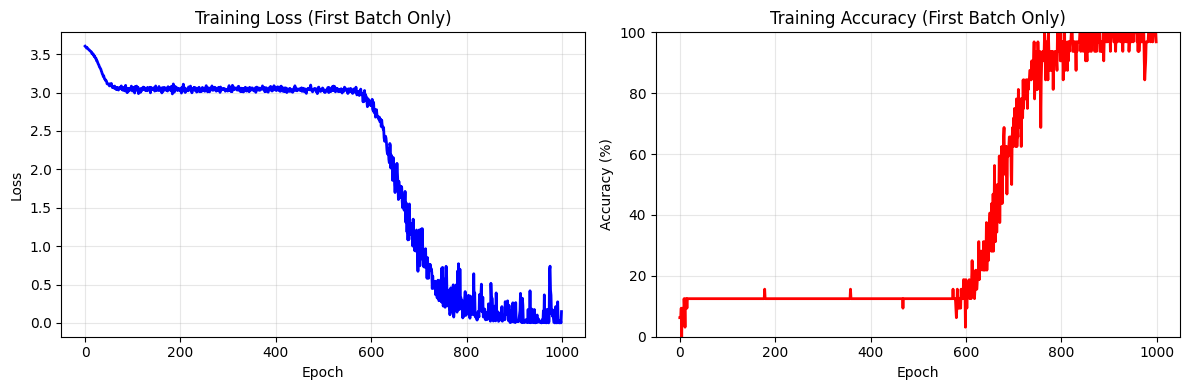

In [ ]:
def test_gradient_descent_with_first_batch(
    model, train_loader, device, num_epochs=100, lr=0.001
):
    """
    Test if gradient descent is working by overfitting to the first batch.

    Args:
        model: Your neural network model
        train_loader: Training data loader
        device: Device to run on (cpu/cuda)
        num_epochs: Number of epochs to train
        lr: Learning rate
    """

    # Get the first batch and keep it fixed
    first_batch = next(iter(train_loader))
    images, labels = first_batch
    images, labels = images.to(device), labels.to(device)

    print(f"Batch size: {images.shape[0]}")
    print(f"Image shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Unique labels in batch: {torch.unique(labels).tolist()}")

    # Setup optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to store metrics
    losses = []
    accuracies = []

    # Training loop - only on the first batch
    model.train()
    print("\nStarting overfitting test...")

    for epoch in tqdm(range(num_epochs)):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping: clip all gradients to max_norm=1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().mean().item() * 100

        # Store metrics
        losses.append(loss.item())
        accuracies.append(accuracy)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%"
            )

    # Final results
    final_loss = losses[-1]
    final_accuracy = accuracies[-1]

    print(f"\n=== RESULTS ===")
    print(f"Initial Loss: {losses[0]:.4f}")
    print(f"Final Loss: {final_loss:.4f}")
    print(f"Initial Accuracy: {accuracies[0]:.2f}%")
    print(f"Final Accuracy: {final_accuracy:.2f}%")

    # Check if gradient descent is working
    loss_decreased = final_loss < losses[0]
    accuracy_improved = final_accuracy > accuracies[0]
    near_perfect_accuracy = final_accuracy > 95.0

    print(f"\n=== GRADIENT DESCENT CHECK ===")
    print(f"✓ Loss decreased: {loss_decreased} ({losses[0]:.4f} -> {final_loss:.4f})")
    print(
        f"✓ Accuracy improved: {accuracy_improved} ({accuracies[0]:.2f}% -> {final_accuracy:.2f}%)"
    )
    print(f"✓ Near perfect accuracy (>95%): {near_perfect_accuracy}")

    if loss_decreased and accuracy_improved and near_perfect_accuracy:
        print("🎉 SUCCESS: Gradient descent is working properly!")
    elif loss_decreased and accuracy_improved:
        print(
            "⚠️  PARTIAL SUCCESS: Gradient descent is working but might need more epochs or different hyperparameters"
        )
    else:
        print("❌ FAILURE: Gradient descent might not be working properly")
        print(
            "   Try: lower learning rate, check model architecture, verify data preprocessing"
        )

    # Plot the results
    plot_training_curves(losses, accuracies)

    return losses, accuracies


def plot_training_curves(losses, accuracies):
    """Plot loss and accuracy curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot loss
    ax1.plot(losses, "b-", linewidth=2)
    ax1.set_title("Training Loss (First Batch Only)")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(accuracies, "r-", linewidth=2)
    ax2.set_title("Training Accuracy (First Batch Only)")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()


# Example usage:
# Assuming you have your model and train_loader ready:
model_noBN = MobileNetV2_noBN(num_classes=37).to(device)


# Custom weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        # He initialization for ReLU
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        # He initialization for ReLU
        nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)


# Apply initialization
model.apply(init_weights)


# Test gradient descent
losses, accuracies = test_gradient_descent_with_first_batch(
    model=model_noBN,
    train_loader=loader_train,
    device=device,
    num_epochs=1000,
    lr=0.0001,
)

These results are rather curious, considering that we were able to train the model on the same dataset before - but with different hyperparameters - and obtained the following results (we failed to replicate these results later, and therefore are not including the exact hyperparameters):

<figure style="text-align: center;">
  <img src="https://i.ibb.co/Mkzk8R51/removing-batch-norm-2.png" alt="removing_batch_norm">
</figure>

### Removing the residual blocks

In [ ]:
class ConvBNReLU_noRes(nn.Sequential):
    """
    Depthwise Separable Convolution with Batch Normalization and ReLU activation.
    This defines a convolution + batch normalization + ReLU activation block.

    groups=1 means it's a normal convolution by default.

    If groups equals the number of input channels, it becomes a depthwise convolution.

    Padding is set so that the output has the same spatial size when stride=1.
    """

    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(
                in_planes,
                out_planes,
                kernel_size,
                stride,
                padding,
                groups=groups,
                bias=False,
            ),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(),
        )

    def __repr__(self):
        return (
            f"ConvBNReLU({self.in_planes} -> {self.out_planes}, "
            f"k={self.kernel_size}, s={self.stride}, g={self.groups})"
        )


# Inverted Residual Block
class InvertedResidual_noRes(nn.Module):
    """
    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride for the depthwise convolution. Controls spatial downsampling.
                      Usually 1 (no downsampling) or 2 (downsampling by factor 2).
        expand_ratio (int or float): Expansion factor to increase the number of channels
                                    before the depthwise convolution. The input channels
                                    are multiplied by this factor to get the hidden dimension.

    Description:
        The block first expands the input channels by 'expand_ratio' using a pointwise (1x1) convolution,
        then applies a depthwise convolution with specified stride, and finally projects the
        channels back to 'oup' using another pointwise convolution. A residual connection
        is applied if stride == 1 and input/output channels are the same.
    """

    def __init__(self, inp, oup, stride, expand_ratio, use_res_connect=True):
        super().__init__()
        self.stride = stride

        # number of channels in the expansion
        hidden_dim = int(inp * expand_ratio)

        # It's only residual if the number of inputs and outputs are the same and we have a stride of 1
        # (only when the input and output are compatible to add to each other without any extra operation)
        self.use_res_connect = self.stride == 1 and inp == oup and use_res_connect

        layers = []
        if expand_ratio != 1:
            # Pointwise
            # if we're expanding, the following pointwise layer is gonna exapnd the number of channels
            # to the set amount. If we're not expanding, it's not needed.
            layers.append(ConvBNReLU_noRes(inp, hidden_dim, kernel_size=1))

        # Depthwise
        # Operation on each channels seperately
        layers.append(
            ConvBNReLU_noRes(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim)
        )

        # Pointwise-linear
        layers.append(
            nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False)
        )
        layers.append(nn.BatchNorm2d(oup))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

    def __repr__(self):
        return (
            f"InvertedResidual(inp={self.inp}, oup={self.oup}, "
            f"stride={self.stride}, expand_ratio={self.expand_ratio})"
        )


# MobileNetV2
class MobileNetV2_No_Res(nn.Module):
    def __init__(self, num_classes=37, width_mult=0.5, dropout=0.2):
        super().__init__()
        # Config: t, c, n, s
        # t: expansion factor, c: output channels, n: number of blocks, s: stride of first block
        self.cfgs = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # First layer
        input_channel = int(32 * width_mult)
        self.last_channel = int(1280 * width_mult) if width_mult > 1.0 else 1280

        # stem layer
        # 3 channels coming in and 32*width_mult coming out
        # this is not a residual block
        layers = [ConvBNReLU_noRes(3, input_channel, stride=2)]

        # Bottleneck layers
        for t, c, n, s in self.cfgs:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(
                    InvertedResidual_noRes(
                        input_channel, output_channel, stride, expand_ratio=t
                    )
                )
                input_channel = output_channel

        # Last conv layer
        layers.append(ConvBNReLU_noRes(input_channel, self.last_channel, kernel_size=1))
        self.features = nn.Sequential(*layers)

        # Classifier
        if dropout:
            self.classifier = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(self.last_channel, num_classes),
            )
        else:
            self.classifier = nn.Linear(self.last_channel, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x


model_no_res = MobileNetV2_No_Res(num_classes=37).to(device)
x = torch.randn(1, 3, 224, 224).to(device)
out = model_no_res(x)
print(out.shape)

summary(
    model_no_res,
    input_size=(
        1,
        3,
        cfg["crop_size"],
        cfg["crop_size"],
    ),  # batch_size must be included
    device=device.type,
    depth=2,
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
)

torch.Size([1, 37])


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2_No_Res                            [1, 3, 224, 224]          [1, 37]                   --                        --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─ConvBNReLU_noRes: 2-1                  [1, 3, 224, 224]          [1, 16, 112, 112]         464                       --                        5,419,040
│    └─InvertedResidual_noRes: 2-2            [1, 16, 112, 112]         [1, 8, 112, 112]          320                       --                        3,412,016
│    └─InvertedResidual_noRes: 2-3            [1, 8, 112, 112]          [1, 12, 56, 56]           1,608                     --                        7,978,200
│    └─InvertedResidual_noRes: 2-4            [1, 12, 

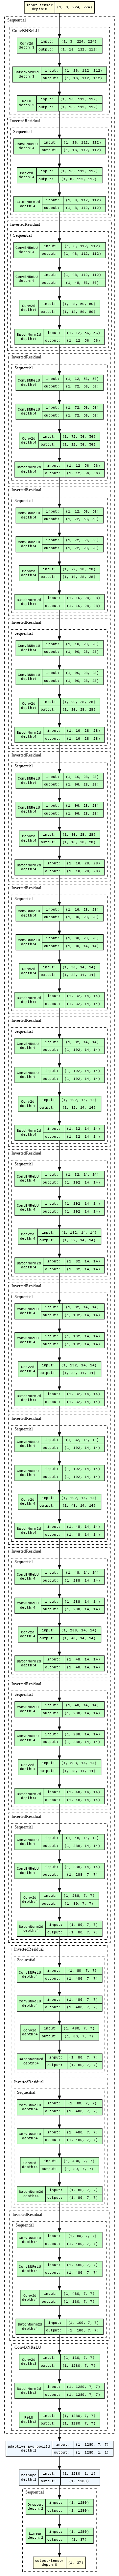

In [ ]:
graph = draw_graph(
    model_no_res,
    input_size=(1, 3, 224, 224),
    expand_nested=True,  # already doing this — good!
    depth=4,  # increase this to show deeper modules (default is 3)
)
graph.visual_graph.render("mobilenetv2_tree", format="png")
IPython_Image(filename="mobilenetv2_tree.png")

As can be seen in the illustration, there are no more residual connections (no identity is added back to the network).

In [ ]:
cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 2e-3,
    "wd": 1e-4,
    "ls": 0.1,
    "step_size": 5,
    "run_name": "No-res",
}

In [ ]:
model_no_res = MobileNetV2_No_Res(num_classes=37).to(device)
trainer = Trainer(
    model_no_res, loader_train, loader_val, loader_test, device, num_classes
)
trainer.train()

Epoch: 100%|██████████| 150/150 [31:48<00:00, 12.73s/it]


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.66      0.64        50
           1       0.41      0.52      0.46        50
           2       0.28      0.14      0.19        50
           3       0.54      0.58      0.56        50
           4       0.48      0.58      0.52        50
           5       0.60      0.74      0.66        50
           6       0.64      0.82      0.72        50
           7       0.67      0.71      0.69        49
           8       0.60      0.50      0.54        50
           9       0.36      0.30      0.33        50
          10       0.49      0.42      0.45        50
          11       0.76      0.79      0.77        47
          12       0.55      0.24      0.33        50
          13       0.41      0.44      0.42        50
          14       0.51      0.58      0.54        50
          15       0.61      0.76      0.68        50
          16       0.48      0.48      0.48        50
   

Residual blocks are a fundamental part of the architecture, and omitting them reduces performance significantly.

### Reducing the width multiplier

Determining the exact sufficient number of parameters is a tedious task, especially since hyperparameters can alter this value. Therefore, instead of making incremental adjustments, we chose to test the model with double and half the number of parameters.

In [ ]:
cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 2e-3,
    "wd": 1e-4,
    "ls": 0.1,
    "step_size": 5,
    "run_name": "width0.25",
}

In [ ]:
model_half_width = MobileNetV2(num_classes=37, width_mult=0.25).to(device)
x = torch.randn(1, 3, 224, 224).to(device)
out = model(x)
print(out.shape)

summary(
    model_half_width,
    input_size=(
        1,
        3,
        cfg["crop_size"],
        cfg["crop_size"],
    ),  # batch_size must be included
    device=device.type,
    depth=2,
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
)

torch.Size([1, 37])


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2                                   [1, 3, 224, 224]          [1, 37]                   --                        --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─ConvBNReLU: 2-1                        [1, 3, 224, 224]          [1, 8, 112, 112]          232                       --                        2,709,520
│    └─InvertedResidual: 2-2                  [1, 8, 112, 112]          [1, 4, 112, 112]          128                       --                        1,304,600
│    └─InvertedResidual: 2-3                  [1, 4, 112, 112]          [1, 6, 56, 56]            564                       --                        2,333,292
│    └─InvertedResidual: 2-4                  [1, 6, 5

In [ ]:
trainer = Trainer(
    model_half_width, loader_train, loader_val, loader_test, device, num_classes
)
trainer.train()

Epoch: 100%|██████████| 150/150 [31:31<00:00, 12.61s/it]


Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67        50
           1       0.41      0.42      0.42        50
           2       0.31      0.24      0.27        50
           3       0.61      0.68      0.64        50
           4       0.56      0.58      0.57        50
           5       0.60      0.78      0.68        50
           6       0.57      0.78      0.66        50
           7       0.71      0.76      0.73        49
           8       0.54      0.44      0.48        50
           9       0.72      0.58      0.64        50
          10       0.43      0.42      0.42        50
          11       0.74      0.83      0.78        47
          12       0.55      0.36      0.43        50
          13       0.40      0.40      0.40        50
          14       0.60      0.50      0.54        50
          15       0.57      0.72      0.64        50
          16       0.64      0.56      0.60        50
   

Reducing the parameters by around 60% caused the performance to drop by approximately 11%, which is just above the performance threshold expected in the project description. This demonstrates that there is significant room to reduce the number of parameters if we want our model to be lightweight and cost-efficient.

### Increasing the width multiplier

Just for demonstration purposes, we used the full MobileNet model, which has around three times the number of parameters. We chose to use half the width so that we could have a well-performing model with a low number of parameters. This led to a loss of 5 percentage points in accuracy but drastically reduced the number of parameters.

In [ ]:
model = MobileNetV2(num_classes=37).to(device)

cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 2e-3,
    "wd": 1e-4,
    "ls": 0.1,
    "step_size": 5,
    "run_name": "width1.0",
}

In [ ]:
model = MobileNetV2(num_classes=37, width_mult=1.0).to(device)
x = torch.randn(1, 3, 224, 224).to(device)
out = model(x)
print(out.shape)

summary(
    model,
    input_size=(
        1,
        3,
        cfg["crop_size"],
        cfg["crop_size"],
    ),  # batch_size must be included
    device=device.type,
    depth=2,
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
)

torch.Size([1, 37])


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2                                   [1, 3, 224, 224]          [1, 37]                   --                        --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─ConvBNReLU: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         928                       --                        10,838,080
│    └─InvertedResidual: 2-2                  [1, 32, 112, 112]         [1, 16, 112, 112]         896                       --                        10,035,296
│    └─InvertedResidual: 2-3                  [1, 16, 112, 112]         [1, 24, 56, 56]           5,136                     --                        29,202,864
│    └─InvertedResidual: 2-4                  [1, 2

In [ ]:
trainer = Trainer(model, loader_train, loader_val, loader_test, device, num_classes)
trainer.train()

Epoch: 100%|██████████| 150/150 [38:38<00:00, 15.46s/it]


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87        50
           1       0.71      0.74      0.73        50
           2       0.40      0.36      0.38        50
           3       0.71      0.74      0.73        50
           4       0.62      0.68      0.65        50
           5       0.81      0.76      0.78        50
           6       0.75      0.90      0.82        50
           7       0.87      0.92      0.89        49
           8       0.91      0.80      0.85        50
           9       0.84      0.76      0.80        50
          10       0.77      0.66      0.71        50
          11       0.74      0.96      0.83        47
          12       0.80      0.56      0.66        50
          13       0.60      0.66      0.63        50
          14       0.85      0.68      0.76        50
          15       0.66      0.84      0.74        50
          16       0.74      0.74      0.74        50
   

## Regularization changes

### Removing Dropout

The effect of dropout during training was rather minimal, as it only improved the model by one percentage point.

In [ ]:
cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 2e-3,
    "wd": 1e-4,
    "ls": 0.1,
    "step_size": 5,
    "run_name": "NoDropout",
}

In [ ]:
model_no_dropout = MobileNetV2(num_classes=37, dropout=0).to(device)
trainer = Trainer(
    model_no_dropout, loader_train, loader_val, loader_test, device, num_classes
)
trainer.train()

Epoch: 100%|██████████| 150/150 [31:28<00:00, 12.59s/it]


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76        50
           1       0.64      0.64      0.64        50
           2       0.43      0.44      0.44        50
           3       0.68      0.72      0.70        50
           4       0.64      0.64      0.64        50
           5       0.67      0.76      0.71        50
           6       0.67      0.82      0.74        50
           7       0.84      0.86      0.85        49
           8       0.71      0.60      0.65        50
           9       0.81      0.78      0.80        50
          10       0.72      0.52      0.60        50
          11       0.76      0.94      0.84        47
          12       0.76      0.56      0.64        50
          13       0.59      0.54      0.56        50
          14       0.69      0.70      0.69        50
          15       0.67      0.78      0.72        50
          16       0.68      0.64      0.66        50
   

### Removing Data Augmentation

In [ ]:
cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 2e-3,
    "wd": 1e-4,
    "ls": 0.1,
    "step_size": 5,
    "run_name": "noAugment",
}

In [ ]:
def augment(augmentation=True):
    if augmentation:
        data_transforms = T.Compose(
            [
                T.Resize(cfg["resize_size"]),
                T.CenterCrop(cfg["crop_size"]),
                T.RandomResizedCrop(cfg["crop_size"]),
                T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                T.RandomRotation(10),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
    else:
        data_transforms = T.Compose(
            [
                T.Resize(cfg["resize_size"]),
                T.CenterCrop(cfg["crop_size"]),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
    data_train = OxfordPetDataset("train", data_transforms)
    loader_train = DataLoader(
        data_train,
        batch_size=cfg["batch_size"],
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    return loader_train


loader_train = augment(False)

In [ ]:
model_no_dropout = MobileNetV2(num_classes=37).to(device)

trainer = Trainer(
    model_no_dropout, loader_train, loader_val, loader_test, device, num_classes
)
trainer.train()

Epoch: 100%|██████████| 150/150 [28:34<00:00, 11.43s/it]


Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.24      0.26        50
           1       0.32      0.22      0.26        50
           2       0.08      0.10      0.09        50
           3       0.31      0.42      0.36        50
           4       0.20      0.18      0.19        50
           5       0.41      0.58      0.48        50
           6       0.45      0.52      0.48        50
           7       0.49      0.84      0.62        49
           8       0.21      0.24      0.22        50
           9       0.17      0.22      0.19        50
          10       0.13      0.08      0.10        50
          11       0.42      0.47      0.44        47
          12       0.27      0.14      0.18        50
          13       0.17      0.16      0.17        50
          14       0.32      0.18      0.23        50
          15       0.23      0.32      0.27        50
          16       0.32      0.26      0.29        50
   

Flipping the train loader to the previous setup.

In [ ]:
loader_train = augment()

### Removing Label Smoothing

Removing label smoothing dropped performance by 6%, which is a substantial decrease. This highlights how sensitive our task is and how valuable certain regularization techniques can be for improving performance.

In [ ]:
cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 2e-3,
    "wd": 1e-4,
    "ls": 0.0,
    "step_size": 5,
    "run_name": "noLabelSmoothing",
}

In [ ]:
model_noLS = MobileNetV2(num_classes=37).to(device)
trainer = Trainer(
    model_noLS, loader_train, loader_val, loader_test, device, num_classes
)
trainer.train()

Epoch: 100%|██████████| 150/150 [36:42<00:00, 14.68s/it]


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.76      0.71        50
           1       0.48      0.52      0.50        50
           2       0.30      0.34      0.32        50
           3       0.62      0.68      0.65        50
           4       0.66      0.58      0.62        50
           5       0.72      0.68      0.70        50
           6       0.76      0.84      0.80        50
           7       0.79      0.84      0.81        49
           8       0.60      0.64      0.62        50
           9       0.64      0.70      0.67        50
          10       0.60      0.52      0.56        50
          11       0.80      0.87      0.84        47
          12       0.53      0.36      0.43        50
          13       0.46      0.44      0.45        50
          14       0.54      0.66      0.59        50
          15       0.61      0.62      0.61        50
          16       0.80      0.66      0.73        50
   

### Removing Weight Decay

Removing weight decay reduces performance by 5%, which is almost as significant as the effect of label smoothing.

In [ ]:
model = MobileNetV2(num_classes=37).to(device)

cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 2e-3,
    "wd": 0.0,
    "ls": 0.1,
    "step_size": 5,
    "run_name": "noWD",
}

In [ ]:
model_noWD = MobileNetV2(num_classes=37).to(device)
trainer = Trainer(
    model_noWD, loader_train, loader_val, loader_test, device, num_classes
)
trainer.train()

Epoch: 100%|██████████| 150/150 [36:41<00:00, 14.68s/it]


Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.58      0.63        50
           1       0.50      0.50      0.50        50
           2       0.46      0.46      0.46        50
           3       0.68      0.76      0.72        50
           4       0.60      0.60      0.60        50
           5       0.69      0.70      0.69        50
           6       0.66      0.82      0.73        50
           7       0.85      0.82      0.83        49
           8       0.65      0.52      0.58        50
           9       0.61      0.68      0.64        50
          10       0.61      0.62      0.61        50
          11       0.78      0.81      0.79        47
          12       0.64      0.42      0.51        50
          13       0.55      0.54      0.55        50
          14       0.58      0.70      0.64        50
          15       0.62      0.68      0.65        50
          16       0.71      0.58      0.64        50
   

Although we anticipated some improvements from label smoothing and weight decay, their impact exceeded our expectations. Surprisingly, dropout did not play as significant a role as we had expected. It is possible that, without label smoothing and weight decay, dropout would have become considerably more important, especially since vision tasks often suffer from limited training data, making overfitting a common challenge.

## Ablation study summary

The following table summarizes the performance impact of removing key components from our baseline model (MobileNetV2 with a 0.5x width multiplier).

| Experiment                           | Parameters | Test Accuracy (%) | Performance Change (Δ) |
| :----------------------------------- | :--------: | :---------------: | :--------------------: |
| **Baseline (0.5x width)**            | **~732k**  |     **73.2%**     |           **-**          |
|                                      |            |                   |                        |
| ***Architectural Ablations***        |            |                   |                        |
| No Batch Normalization               |   ~722k    |       2.7%        |        **-70.5%**        |
| No Residual Connections              |   ~732k    |       57.9%       |        **-15.3%**        |
| Width Multiplier: 0.25x              |   ~283k    |       61.6%       |        **-11.6%**        |
| Width Multiplier: 1.0x               |   ~2.3M    |       77.6%       |         **+4.4%**        |
|                                      |            |                   |                        |
| ***Regularization Ablations***       |            |                   |                        |
| No Data Augmentation                 |   ~732k    |       31.1%       |        **-42.1%**        |
| No Label Smoothing                   |   ~732k    |       66.9%       |         **-6.3%**        |
| No Weight Decay                      |   ~732k    |       68.2%       |         **-5.0%**        |
| No Dropout                           |   ~732k    |       73.1%       |         **-0.1%**        |

**Key takeaway**: Data Augmentation and Batch Normalization are the most critical components, while Label Smoothing and Weight Decay provide significant performance gains.

# Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

In [ ]:
WANDB_USER = "parsa-pmk"
WANDB_PROJECT = "Task2"

While freezing the entire model and working with just the head, we realized that we could achieve better results by adding a two-layer neural network as the head, with dropout layers in between to help regulate overfitting.

#### Estimating Effective Dropout Rate

We have two dropout layers in the model:

- First dropout: `Dropout(0.5)` → \( D_1 = 0.4 \)
- Second dropout: `Dropout(0.3)` → \( D_2 = 0.2 \)

To approximate the **effective retention rate** (i.e., the fraction of activations that survive both dropout layers), we multiply the retention at each stage:

$\text{Effective retention} \approx (1 - D_1) \times (1 - D_2) = 0.6 \times 0.8 = 0.48$

Then the **effective dropout rate** becomes:

$\text{Effective dropout rate} \approx 1 - 0.48 = 0.52 \quad \text{or } 52\%$

> ⚠️ Note: This is a rough approximation. Dropout layers affect different parts of the network, so this calculation assumes independence and uniform activation survival.

## 2A. Fine-tune ResNet

Since we are using the same hyperparameters as in the first task, we also use the same trainer as before (since it has only one phase) and attempt to fine-tune the entire model.

In [ ]:
cfg = {
    # Pre-processing's parameters.
    "resize_size": 256,
    "crop_size": 224,
    # Training's parameters.
    "batch_size": 32,
    "num_epochs": 150,
    # Optimizer's parameters.
    "lr": 2e-3,
    "wd": 1e-4,
    "ls": 0.1,
    "step_size": 5,
    "run_name": "2A-prev-hype-full-model",
}

In [ ]:
model_resnet_prev_hype = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_resnet_prev_hype.fc.in_features

# Better classifier head
model_resnet_prev_hype.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 37),
)

model_resnet_prev_hype.to(device)
print("model initialized")

model initialized


In [ ]:
trainer = Trainer(
    model_resnet_prev_hype, loader_train, loader_val, loader_test, device, num_classes
)
trainer.train()

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.85        50
           1       0.75      0.84      0.79        50
           2       0.53      0.56      0.54        50
           3       0.82      0.84      0.83        50
           4       0.66      0.74      0.70        50
           5       0.81      0.84      0.82        50
           6       0.80      0.86      0.83        50
           7       0.96      0.96      0.96        49
           8       0.88      0.76      0.82        50
           9       0.81      0.96      0.88        50
          10       0.84      0.82      0.83        50
          11       0.90      0.98      0.94        47
          12       0.87      0.68      0.76        50
          13       0.76      0.84      0.80        50
          14       0.79      0.74      0.76        50
          15       0.86      0.86      0.86        50
          16       0.85      0.82      0.84        50
   

Training with the former trainer made for our MobileNet model with all the features set as trainable:

<figure style="text-align: center;">
  <img src="https://i.ibb.co/zTcVBr9g/fine-tuning.png" alt="fine-tuning">
</figure>

## 2B. Fine-tuning a partially frozen model with a custom trainer

We developed a customized trainer with a three-phase training strategy:

1. **Phase 1:** Train only the classifier head.  
2. **Phase 2:** Train the head and the fourth ResNet block (high-level feature extractor).  
3. **Phase 3:** Train the head, the fourth ResNet block, and the third ResNet block (mid-level feature extractor).  

We avoided fine-tuning the entire model because it increased sensitivity to hyperparameters and led to overfitting on our dataset, which is relatively small. Gradually unfreezing layers allows more stable training and better generalization.

**Additional improvements:**

- **Freezing BatchNorm layers:** Setting the batch normalization layers of frozen blocks to evaluation mode prevented their running statistics from updating and improved overall accuracy by ~1%.  
- **Test-Time Augmentation (TTA):** Using 10 augmented versions of each input (e.g., flips and rotations) at inference further increased accuracy by ~1%. Note that the overall reports are written excluding the TTA method.


**Attention:**
After some trial and error, we decided to skip the third phase for our final training.

In [ ]:
class Trainer:
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        test_loader: DataLoader,
        device: torch.device,
        num_classes: int,
    ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.num_classes = num_classes

        # Configuration for Mixup and Grad Clipping from the cfg dictionary
        self.use_mixup = cfg.get("use_mixup", False)
        self.mixup_alpha = cfg.get("mixup_alpha", 0.4)
        self.grad_clip_norm = cfg.get("grad_clip_norm", None)
        if self.use_mixup:
            print(f"INFO: Mixup enabled with alpha = {self.mixup_alpha}")

        self.model = model.to(device)
        self.step = 0
        self.best_acc = 0.0
        self.best_model = None

        wandb.init(
            name=cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=cfg
        )
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    # ---------- PHASE DEFINITIONS ----------
    def phase_1(self):
        """Train only the classifier head"""
        self.head_params = self.model.fc.parameters()
        self.backbone_params = [
            p for n, p in self.model.named_parameters() if not n.startswith("fc")
        ]
        for param in self.backbone_params:
            param.requires_grad = False

        self.optimizer = AdamW(self.head_params, lr=cfg["lr"], weight_decay=cfg["wd"])
        self.num_epochs = cfg["phase_1_num_epochs"]
        num_steps = self.num_epochs * len(self.train_loader)
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=cfg["lr"],
            total_steps=num_steps,
            div_factor=25.0,
            final_div_factor=1e4,
            anneal_strategy="cos",
            pct_start=0.2,
        )

    def phase_2(self):
        """Unfreeze last block + head"""
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        for param in self.model.fc.parameters():
            param.requires_grad = True

        self.last_block_params = self.model.layer4.parameters()
        self.head_params = self.model.fc.parameters()
        param_groups = [
            {"params": self.model.layer4.parameters(), "lr": cfg["lr"] * 0.1},
            {"params": self.model.fc.parameters(), "lr": cfg["lr"] * 1.0},
        ]
        self.optimizer = AdamW(param_groups, weight_decay=cfg["wd"])
        self.num_epochs = cfg["phase_2_num_epochs"]
        num_steps = self.num_epochs * len(self.train_loader)
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=[g["lr"] for g in param_groups],
            total_steps=num_steps,
            div_factor=25.0,
            final_div_factor=1e4,
            anneal_strategy="cos",
            pct_start=0.3,
        )

    def phase_3(self):
        """Fine-tune the full model with smaller LRs for early layers"""

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer3.parameters():
            param.requires_grad = True

        for param in self.model.layer4.parameters():
            param.requires_grad = True
        for param in self.model.fc.parameters():
            param.requires_grad = True

        param_groups = [
            {"params": self.model.layer3.parameters(), "lr": cfg["lr"] * 0.05},
            {"params": self.model.layer4.parameters(), "lr": cfg["lr"] * 0.1},
            {"params": self.model.fc.parameters(), "lr": cfg["lr"] * 1.0},
        ]
        self.optimizer = AdamW(param_groups, weight_decay=cfg["wd"])

        self.num_epochs = cfg["phase_3_num_epochs"]
        num_steps = self.num_epochs * len(self.train_loader)
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=[g["lr"] for g in param_groups],
            total_steps=num_steps,
            div_factor=25.0,
            final_div_factor=1e4,
            anneal_strategy="cos",
            pct_start=0.3,
        )

    # ---------- TRAINING LOOPS ----------
    def phase_1_loop(self):
        self.model.train()
        # freeze BN stats in backbone
        for name, module in self.model.named_modules():
            if not name.startswith("fc") and isinstance(
                module, (nn.BatchNorm2d, nn.BatchNorm1d)
            ):
                module.eval()

    def phase_2_loop(self):
        self.model.train()
        # freeze BN stats in earlier layers
        for name, module in self.model.named_modules():
            if not (name.startswith("fc") or name.startswith("layer4")):
                if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
                    module.eval()

    def phase_3_loop(self):
        self.model.train()
        # freeze BN stats in earlier layers
        for name, module in self.model.named_modules():
            if not (
                name.startswith("fc")
                or name.startswith("layer4")
                or name.startswith("layer3")
            ):
                if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
                    module.eval()

    # ---------- GENERIC EPOCH TRAINING ----------
    def train_phase(self, loop_fn):
        for _ in tqdm(range(self.num_epochs), desc="Epoch"):
            loop_fn()
            for imgs, labels in self.train_loader:
                imgs, labels = imgs.to(self.device), labels.to(self.device)

                #######################################################
                # # Conditional Mixup implementation
                # if self.use_mixup:
                #     mixed_imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, self.mixup_alpha, self.device)
                #     pred = self.model(mixed_imgs)

                #     # Create a criterion function that includes label smoothing
                #     criterion = lambda p, t: F.cross_entropy(p, t, label_smoothing=cfg.get("ls", 0.0))
                #     loss = mixup_criterion(criterion, pred, labels_a, labels_b, lam)
                # else:
                #     # Original training step
                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels, label_smoothing=cfg.get("ls", 0.0))
                #######################################################

                if torch.isnan(loss):
                    print("Loss is NaN! Stopping.")
                    return

                self.optimizer.zero_grad()
                loss.backward()

                # Optional gradient clipping
                if self.grad_clip_norm:
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(), self.grad_clip_norm
                    )

                self.optimizer.step()
                self.scheduler.step()

                if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})
                self.step += 1

            self.eval("train")
            self.eval("val")

    # ---------- FIT PIPELINE ----------
    def fit(self):
        phases = [
            ("phase_1", self.phase_1, self.phase_1_loop),
            ("phase_2", self.phase_2, self.phase_2_loop),
            # ("phase_3", self.phase_3, self.phase_3_loop)
        ]
        for name, init_fn, loop_fn in phases:
            print(f"=== Starting {name} ===")
            init_fn()
            self.train_phase(loop_fn)

        self.test()
        wandb.finish()

    # ---------- LOGGING ----------
    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    # ---------- EVAL & TEST ----------
    @torch.no_grad()
    def eval(self, split: str) -> None:
        self.model.eval()
        loader = self.train_loader if split == "train" else self.val_loader
        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        self.logfn({f"{split}/loss": loss})
        self.logfn({f"{split}/acc": accuracy})

        if accuracy > self.best_acc and split == "val":
            self.best_acc = accuracy
            torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            self.best_model = copy.deepcopy(self.model)

    # ---- Test Time Augmentation (Enhanced) ----
    def enhanced_tta_evaluation(self, model, loader_test, num_tta=10):
        model.eval()
        test_acc, total = 0, 0

        # TTA transforms
        tta_transforms = [
            lambda x: x,  # Original
            lambda x: torch.flip(x, dims=[3]),  # Horizontal flip
            lambda x: T.functional.rotate(x, 5),  # Small rotation
            lambda x: T.functional.rotate(x, -5),  # Small rotation other way
            lambda x: torch.flip(T.functional.rotate(x, 3), dims=[3]),  # Flip + rotate
        ]

        with torch.no_grad():
            for images, labels in loader_test:
                images, labels = images.to(device), labels.to(device)

                # Collect predictions from different augmentations
                all_outputs = []
                for i in range(min(num_tta, len(tta_transforms))):
                    augmented_images = tta_transforms[i](images)
                    outputs = model(augmented_images)
                    all_outputs.append(F.softmax(outputs, dim=1))

                # Average the predictions
                final_outputs = torch.mean(torch.stack(all_outputs), dim=0)

                _, preds = torch.max(final_outputs, 1)
                test_acc += preds.eq(labels).sum().item()
                total += images.size(0)

        return test_acc / total

    @torch.no_grad()
    def test(self) -> None:
        self.best_model.eval()
        all_preds, all_labels = [], []
        for imgs, labels in self.test_loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            outputs = self.best_model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()
        cm = confusion_matrix(all_labels, all_preds, normalize="true")
        report = classification_report(
            all_labels, all_preds, output_dict=True, zero_division=0
        )
        print(
            "Classification Report:\n",
            classification_report(all_labels, all_preds, zero_division=0),
        )

        wandb.log(
            {
                "test/tta_accuracy": self.enhanced_tta_evaluation(
                    self.best_model, self.test_loader, num_tta=10
                ),
                "test/accuracy": report["accuracy"],
                "test/macro_avg_precision": report["macro avg"]["precision"],
                "test/macro_avg_recall": report["macro avg"]["recall"],
                "test/macro_avg_f1": report["macro avg"]["f1-score"],
                "test/weighted_avg_precision": report["weighted avg"]["precision"],
                "test/weighted_avg_recall": report["weighted avg"]["recall"],
                "test/weighted_avg_f1": report["weighted avg"]["f1-score"],
            }
        )

        fig, ax = plt.subplots(figsize=(14, 12))
        sns.heatmap(
            cm,
            annot=False,
            cmap="Blues",
            xticklabels=[str(i) for i in range(self.num_classes)],
            yticklabels=[str(i) for i in range(self.num_classes)],
        )
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_title("Normalized Confusion Matrix")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        wandb.log({"test/confusion_matrix": wandb.Image(fig)})
        plt.close(fig)

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features

# Better classifier head
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 37),
)

model.to(device)

print("model initialized")

model initialized


=== Starting phase_1 ===


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

=== Starting phase_2 ===


Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90        50
           1       0.85      0.78      0.81        50
           2       0.73      0.82      0.77        50
           3       0.94      0.90      0.92        50
           4       0.79      0.90      0.84        50
           5       0.93      0.74      0.82        50
           6       0.77      0.92      0.84        50
           7       0.96      1.00      0.98        49
           8       0.85      0.92      0.88        50
           9       0.84      0.92      0.88        50
          10       0.87      0.92      0.89        50
          11       0.81      0.98      0.88        47
          12       1.00      0.82      0.90        50
          13       0.89      0.94      0.91        50
          14       1.00      0.90      0.95        50
          15       0.92      0.96      0.94        50
          16       0.85      0.92      0.88        50
   

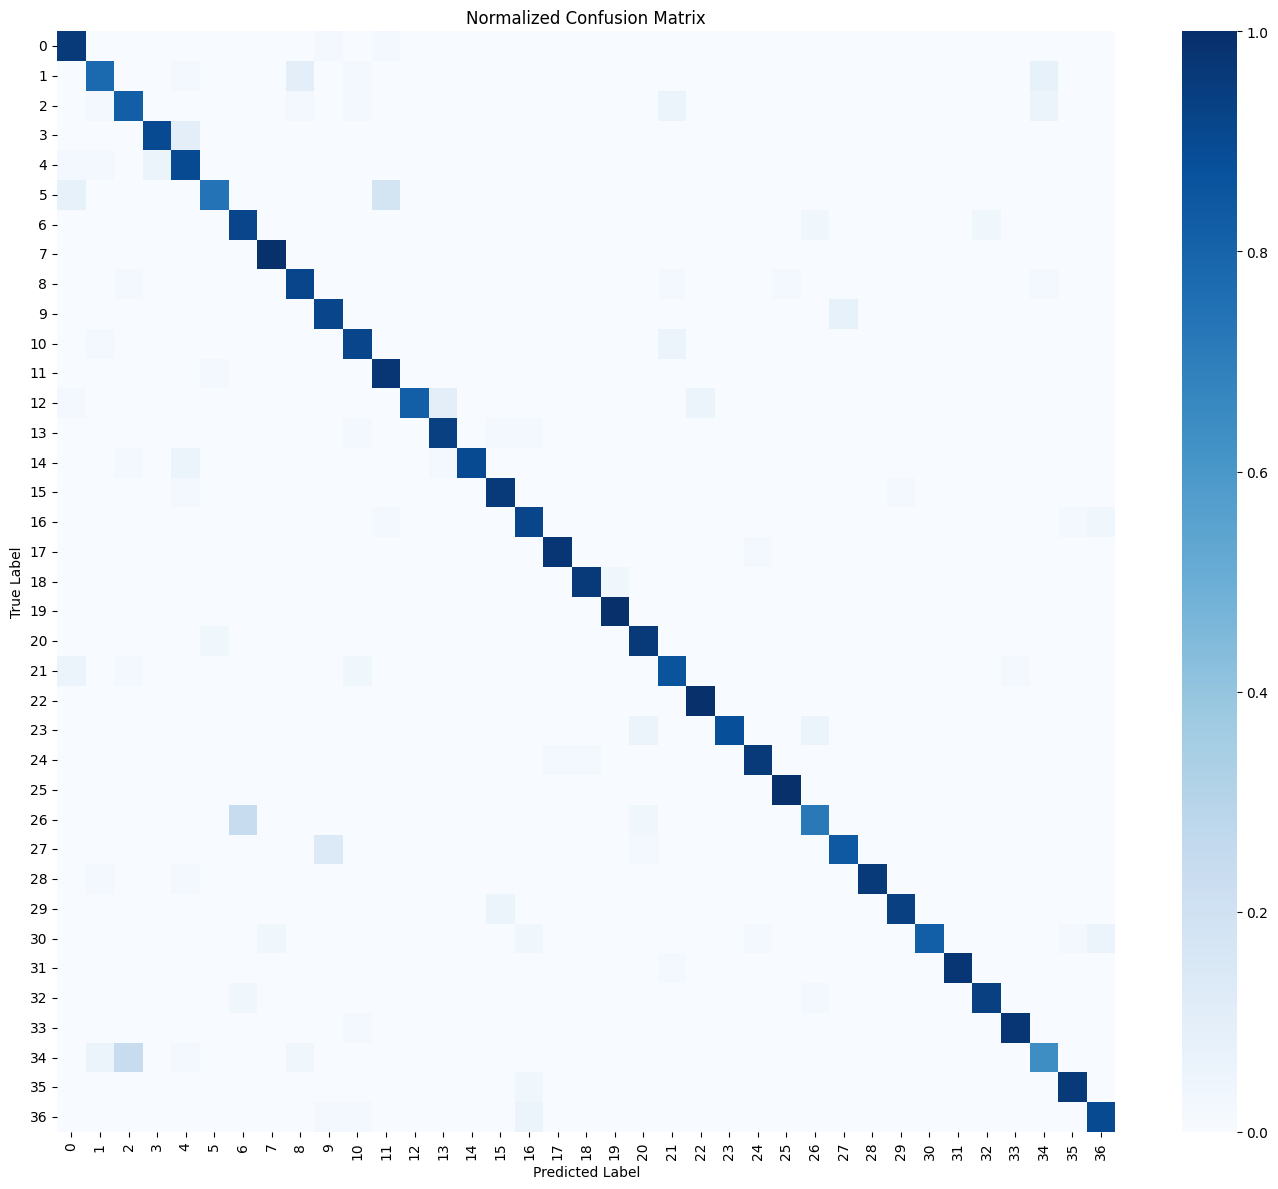

In [ ]:
cfg = {
    # Pre-processing parameters
    "resize_size": 256,
    "crop_size": 224,
    # Training parameters
    "batch_size": 32,  # Increased from 16 for better gradient estimates
    # Phase-specific epoch counts (replaces single num_epochs)
    "phase_1_num_epochs": 20,  # Head-only training
    "phase_2_num_epochs": 60,  # Last layer + head
    "phase_3_num_epochs": 80,  # Full model fine-tuning
    # Optimizer parameters
    "lr": 2e-4,  # Even more conservative base LR
    "wd": 1e-4,  # Reduced weight decay (was 5e-4)
    "ls": 0.1,  # Label smoothing - keep this
    # # Mixup parameters (improved)
    # "use_mixup": False,
    # "mixup_alpha": 0.2,         # Reduced from 0.4 for more conservative mixing
    # New parameters for improved training
    "grad_clip_norm": 1.0,  # Gradient clipping to prevent exploding gradients
    "patience": 5,  # Early stopping patience
    # Removed parameters that are no longer used
    # "step_size": 5,           # Not needed with new schedulers
    # "num_epochs": 80,         # Replaced with phase-specific epochs
}

cfg["run_name"] = (
    f"half_3phase_normal_transforms_{cfg['phase_1_num_epochs']}_{cfg['phase_2_num_epochs']}_{cfg['phase_3_num_epochs']}_{cfg['lr']}"
)

trainer = Trainer(model, loader_train, loader_val, loader_test, device, num_classes)
trainer.fit()

<figure style="text-align: center;">
  <img src="https://i.ibb.co/7Jb3v8Gq/fine-tuning-partially.png" alt="fine-tuning-partially">
</figure>

## References

- Hegde, C. (2021). *DL Demo 5: Finetuning a ResNet* [Video]. YouTube. [https://www.youtube.com/watch?v=AIgWWguKQYI&t=497s](https://www.youtube.com/watch?v=AIgWWguKQYI&t=497s)  
- deeplizard. (2021). *Fine-tuning a Neural Network explained* [Video]. YouTube. [https://www.youtube.com/watch?v=5T-iXNNiwIs](https://www.youtube.com/watch?v=5T-iXNNiwIs)  
- Chilamkurthy, S. (2017). *Transfer Learning for Computer Vision Tutorial*. PyTorch. [https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html](https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
